In [6]:
#input files
infilepath="/home/megan/Desktop/emel_lb1234/3.reformat/"
genomatrix="genos_matrix.csv"
fstpopmatrix="fst_pop.csv"
siteallelematrix="pop_alleles_gdm.csv"

#samples "database"
samplefile="/home/megan/megan/research/eucalyptus/eucalyptus_data/Emelliodora_PlantsSamples.csv"
accessionfile="/home/megan/megan/research/eucalyptus/eucalyptus_data/Emelliodora_Accessions.csv"

#geographic extent polygon
extentpoly="/home/megan/Desktop/emel_lb1234/4.analysis/gdm/emel_dist_polygon/emel_alasuboccur_20k.shp"

#covariate to color by
cov2color="Latitude"
#cov2color="Longitude"
#cov2color="CleanedFileSize"
#cov2color="missing"
#cov2color="PlateName"
#cov2color="GradientOrder"

In [11]:
library(adegenet)
library(fossil)
library(ecodist)
library(raster)
library(rgdal)
library(gdm)
library(maptools)
options(jupyter.plot_mimetypes = "image/png")

Checking rgeos availability: TRUE


In [3]:
#read in genotype matrix
genos=read.delim(paste(infilepath,genomatrix,sep=""), sep=",", header=T)     #read in file
rownames(genos)=genos[,1]                           #change column 1 to row names
#rownames(genos)=substr(genos[,1],9,14)             #get just sample ID from stacks names
genos=genos[,-1]
dim(genos)
genos[1:3,1:5]

[1]  275 9378

,Chr01.14319,Chr01.22984,Chr01.79312,Chr01.79661,Chr01.384722
S45001,NA,NA,0/0,0/0,NA
S45002,NA,0/0,NA,0/0,NA
S45003,0/0,NA,0/0,0/0,0/0


In [4]:
#read in fst matrix
fst=read.delim(paste(infilepath,fstpopmatrix,sep=""), sep=",", header=T)     #read in file
fst_pop_names=fst[,1]                               #get pop names before mangled
fst=fst[,-1]                                        #fix row names
rownames(fst)=colnames(fst)                         
dim(fst)
fst.dist=as.dist(fst)
fst[1:3,1:5]

[1] 36 36

,LB.1,LB.10,LB.11,LB.13,LB.14
LB.1,NA,0.04295878,0.02719413,0.03671601,0.03389006
LB.10,0.04295878,NA,0.04727133,0.04692548,0.06488105
LB.11,0.02719413,0.04727133,NA,0.0487242,0.05395956


In [5]:
#format for input into genid object
genos.filt=genos
#fix loci names so happy
colnames(genos.filt)=gsub(".","_",colnames(genos.filt),fixed=T)
genos.filt[genos.filt == "./."] <- NA
#convert to genid object
genos.gi <- df2genind(genos.filt,sep="/",NA.char=NA)
genos.gi

/// GENIND OBJECT /////////

 // 275 individuals; 9,378 loci; 18,756 alleles; size: 24.3 Mb

 // Basic content
   @tab:  275 x 18756 matrix of allele counts
   @loc.n.all: number of alleles per locus (range: 2-2)
   @loc.fac: locus factor for the 18756 columns of @tab
   @all.names: list of allele names for each locus
   @ploidy: ploidy of each individual  (range: 2-2)
   @type:  codom
   @call: df2genind(X = genos.filt, sep = "/", NA.char = NA)

 // Optional content
   - empty -

In [7]:
#add sample metadata
sampleinfo=read.csv(samplefile, header=TRUE)  #read in sample information with populations 
samplematches=match(sampleinfo$SampleID, indNames(genos.gi))  #subset for just samples in this analysis
samples=sampleinfo[!is.na(samplematches),][order(na.omit(samplematches)),]

accessioninfo=read.csv(accessionfile, header=T)  #read in accession information
accessionmatches=match(samples$AccessionID, accessioninfo$AccessionID)
samples=cbind(samples,accessioninfo$Latitude[accessionmatches],accessioninfo$Longitude[accessionmatches],
              accessioninfo$PopulationName[accessionmatches],accessioninfo$Altitude[accessionmatches],
              accessioninfo$GradientOrder[accessionmatches])
names(samples)[names(samples)=="accessioninfo$Latitude[accessionmatches]"]="Latitude"
names(samples)[names(samples)=="accessioninfo$Longitude[accessionmatches]"]="Longitude"
names(samples)[names(samples)=="accessioninfo$PopulationName[accessionmatches]"]="PopulationName"
names(samples)[names(samples)=="accessioninfo$Altitude[accessionmatches]"]="Altitude"
names(samples)[names(samples)=="accessioninfo$GradientOrder[accessionmatches]"]="GradientOrder"
samples$PopulationName=droplevels(samples$PopulationName) #fix annoying extra level with no assignment

#add missing data metric
samples$missing=rowSums(is.na(genos.filt))/dim(genos.filt)[2]*100

#get color based on ordering of covariate
cov=samples[!duplicated(samples[[cov2color]]), ] #remove duplicates of the covariate
cov=cov[order(cov[[cov2color]]), ]               #sort 
cov$color=rev(rainbow(n=dim(cov)[1],start=0, end=.8))       #add color, rev to invert since neg lats
#cov$color=rainbow(n=dim(cov)[1],start=0, end=.8)

#add color to sample df
colormatches=match(samples[[cov2color]], cov[[cov2color]])  #match color to samples by covariate
samples=cbind(samples, cov$color[colormatches])
names(samples)[names(samples)=="cov$color[colormatches]"]="cov_color"
samples$cov_color=as.character(samples$cov_color)

#resort covariate df so it matches sorted order of populations (for dapc)
poporder=samples[!duplicated(samples$PopulationName), ]
poporder=poporder[order(poporder$PopulationName), ]   

In [8]:
#read in environmental data
clim_vars = getData('worldclim', var='bio', res=2.5, path="/home/megan/megan/research/gis_data")    
#useful bioclim names
names=c(#"Latitude","Longitude","Altitude",
       "Annual Mean Temperature","Mean Diurnal Range","Isothermality","Temperature Seasonality",
       "Max Temperature of Warmest Month","Min Temperature of Coldest Month",
       "Temperature Annual Range","Mean Temperature of Wettest Quarter","Mean Temperature of Driest Quarter",
       "Mean Temperature of Warmest Quarter","Mean Temperature of Coldest Quarter","Annual Precipitation",
       "Precipitation of Wettest Month","Precipitation of Driest Month","Precipitation Seasonality",
       "Precipitation of Wettest Quarter","Precipitation of Driest Quarter",
       "Precipitation of Warmest Quarter","Precipitation of Coldest Quarter",
       "Koppen Class","Temperature/Humidity Zone", "Altitude")
#restrict for our dataset and clean up
range=extent(min(samples$Longitude)-1,max(samples$Longitude)+1,min(samples$Latitude)-1,max(samples$Latitude)+1)
clim_vars_range=crop(clim_vars, range)
rm(clim_vars)

#read in altitude data
#alt=getData('alt', download=T, country='AUS') 
    #altitude (elevation); the data were aggregated from SRTM 90 m resolution data between -60 and 60 latitude
alt=getData('alt', country='AUS', path="/home/megan/megan/research/gis_data/oz_alt")
#alt_range=crop(alt, range)
names(alt)="altitude"  #rename

#read in koppen data
koppen_raw=read.asciigrid("/home/megan/megan/research/gis_data/oz_koppen_classes/kpnall.txt")
koppen_rb=as(koppen_raw, 'RasterBrick')
names(koppen_rb)="koppen"

#read in temp/humidity zone data
tmphu_raw=read.asciigrid("/home/megan/megan/research/gis_data/oz_tmphumid_zones/clim-zones.txt")
tmphu_rb=as(tmphu_raw, 'RasterBrick')
names(tmphu_rb)="tmphu"

#add to samples
altitude=extract(alt, cbind(samples$Longitude, samples$Latitude))
samples=cbind(samples, extract(clim_vars_range, cbind(samples$Longitude, samples$Latitude)),
                       extract(koppen_rb, cbind(samples$Longitude, samples$Latitude)),
                       extract(tmphu_rb, cbind(samples$Longitude, samples$Latitude)),
                       altitude)
#names(samples)[names(samples)=="X.home.megan.megan.research.gis_data.oz_koppen_classes.kpnall.txt"]="koppen"
#names(samples)[names(samples)=="X.home.megan.megan.research.gis_data.oz_tmphumid_zones.clim.zones.txt"]="tmphu"

#resample to make same extent and add to raster stack
koppen_resamp=resample(koppen_rb,clim_vars_range,"bilinear")
clim_vars_range=stack(clim_vars_range,koppen_resamp)
tmphu_resamp=resample(tmphu_rb,clim_vars_range,"bilinear")
clim_vars_range=stack(clim_vars_range,tmphu_resamp)
alt_resamp=resample(alt,clim_vars_range,"bilinear")
clim_vars_range=stack(clim_vars_range,alt_resamp)

#plot(clim_vars_range)

In [9]:
## read in future climate rasters

#2050
bc50mc85=stack()
for (i in 1:19)
    {
        temp_tif=raster(paste("/home/megan/megan/research/gis_data/mc85bi50/mc85bi50",i,".tif",sep=""))
                          # crs="+proj=longlat +datum=WGS84")
        #temp_proj=projectRaster(temp_tif, crs="+proj=longlat +datum=WGS84")
        temp_rb=as(temp_tif, 'RasterBrick')
        ##resample to make same extent and add to raster stack
        temp_resamp=resample(temp_rb,clim_vars_range,"bilinear")
        names(temp_resamp)=paste("bio",i,sep="")
        #stack bricks
        bc50mc85=stack(bc50mc85,temp_resamp)
    }
#change so NAs match the present climate variables
#bc50mc85=bc50mc85[is.na(clim_vars_range[])]=NA
tmp_names=names(bc50mc85)
values(bc50mc85)[is.na(clim_vars_range[])]=NA
names(bc50mc85)=tmp_names

#2070
bc70mc85=stack()
for (i in 1:19)
    {
        temp_tif=raster(paste("/home/megan/megan/research/gis_data/mc85bi70/mc85bi70",i,".tif",sep=""))
        temp_rb=as(temp_tif, 'RasterBrick')
        ##resample to make same extent and add to raster stack
        temp_resamp=resample(temp_rb,clim_vars_range,"bilinear")
        names(temp_resamp)=paste("bio",i,sep="")
        #stack bricks
        bc70mc85=stack(bc70mc85,temp_resamp)
    }
#change so NAs match the present climate variables
tmp_names=names(bc70mc85)
values(bc70mc85)[is.na(clim_vars_range[])]=NA
names(bc70mc85)=tmp_names

Warning message:
In matrix(values, nrow = ncell(x), ncol = nlayers(x)): data length [1692548] is not a sub-multiple or multiple of the number of columns [19]Warning message:
In matrix(values, nrow = ncell(x), ncol = nlayers(x)): data length [1692548] is not a sub-multiple or multiple of the number of columns [19]

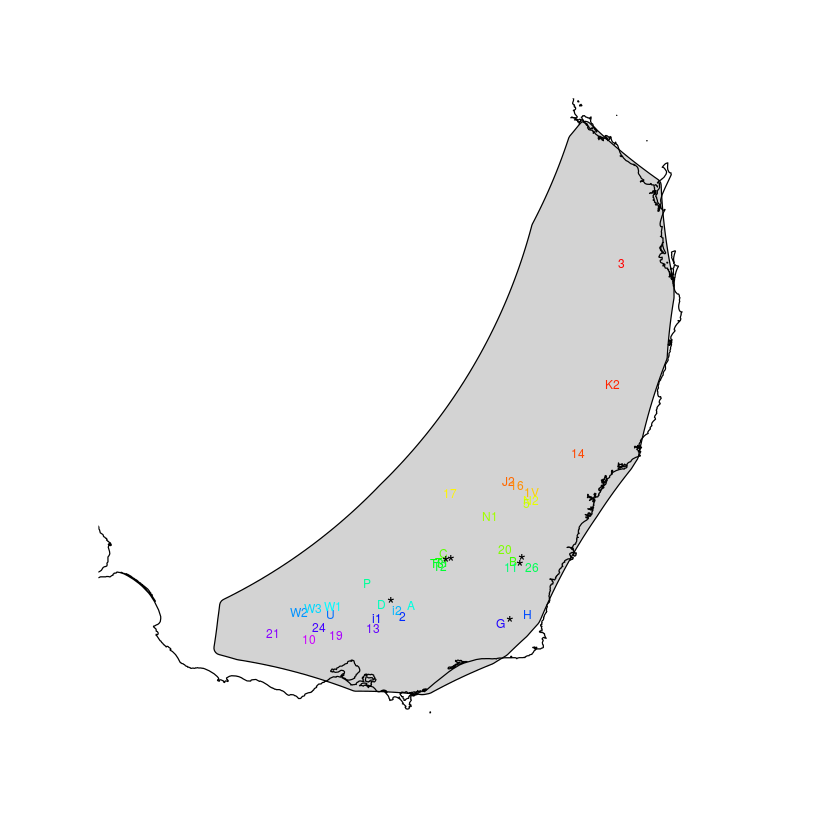

In [17]:
library(oz)
samples_pops=unique(samples[,c(19,20,21,25)])
chambers_pops=subset(samples_pops, PopulationName=="LB-11" | PopulationName=="LB-B" | PopulationName=="LB-D" | 
                     PopulationName=="LB-G" | PopulationName=="LB-T1" | PopulationName=="LB-T3")

#read in extent and visualize
ext=readShapeSpatial(extentpoly)
OzCoast=shapefile("/home/megan/megan/research/gis_data/oz_coast/aus5m_coast_no_norfolk.shp")
plot(ext,col="lightgrey")
#points(units$Longitude, units$Latitude)
plot(OzCoast, add=T)

#pdf(file="map.pdf")
#oz(ylim=c(-40,-27),xlim=c(148,149.7),new=F)
#plot(samples$longitude,samples$latitude, labels=samples$Population)
text(samples_pops$Longitude,samples_pops$Latitude, 
     label=substring(samples_pops$PopulationName, 4), cex = .6, col=samples_pops$cov_color) #add names and colors
text(chambers_pops$Longitude, chambers_pops$Latitude,
     label="   *")



#dev.off()

In [19]:
#pca of genetic distance by individual
genos.dist=dist(genos.gi)
pcoa.genos=dudi.pco(genos.dist,scannf = F, nf = 3)
percent_var=round(100*pcoa.genos$eig/sum(pcoa.genos$eig),1)

Warning message:
In dudi.pco(genos.dist, scannf = F, nf = 3): Non euclidean distance

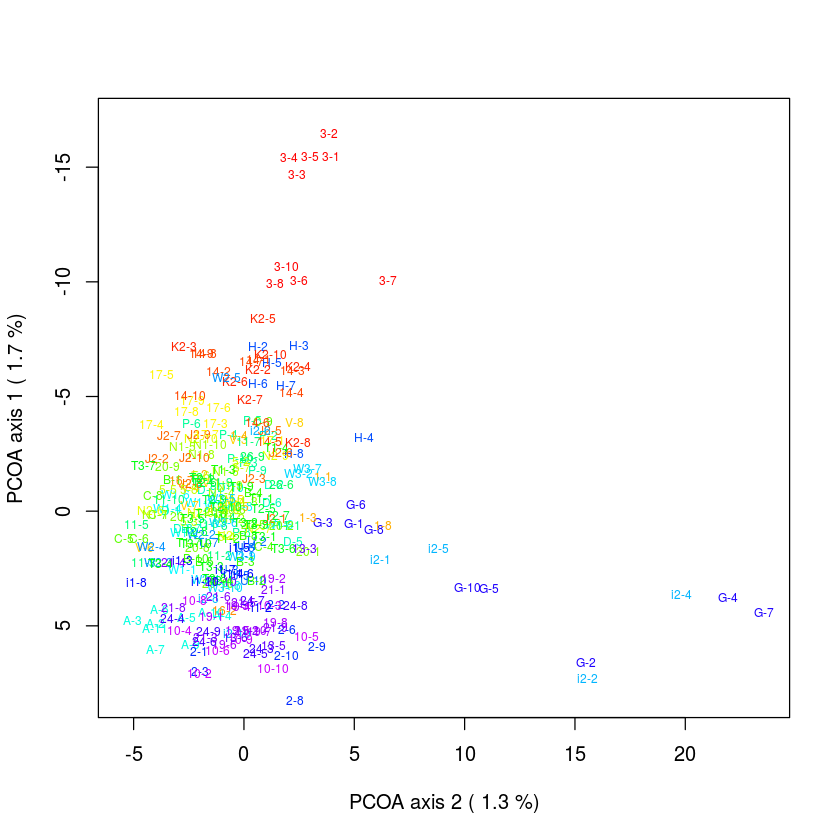

In [20]:
#pdf("emellb_pca_275.pdf")
plot(pcoa.genos$li[,2:1], pch="",
    xlab = paste("PCOA axis 2 (", percent_var[2],"%)"), ylab = paste("PCOA axis 1 (", percent_var[1],"%)"),
    ylim=c(8,-17))
  #  xlim=c(-10,10),ylim=c(-15,10))
text(pcoa.genos$li[,2:1], 
     label=samples$SampleName, cex = .6, col=samples$cov_color) #add names and colors
#dev.off()

Warning message:
In dudi.pco(fst.dist, scannf = F, nf = 3): Non euclidean distance

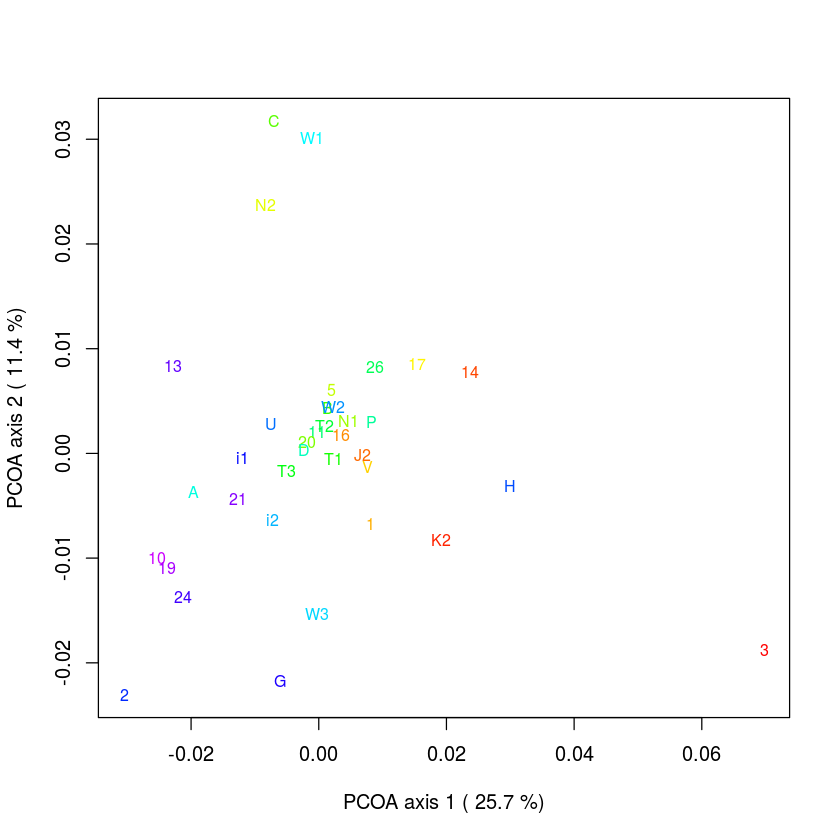

In [21]:
#pca of genetic distance by population fst
#pdf(file="pca.pdf")
pcoa.fst=dudi.pco(fst.dist,scannf = F, nf = 3)
percent_var_site=round(100*pcoa.fst$eig/sum(pcoa.fst$eig),1)
#pdf("emellb_pca_275.pdf")
plot(pcoa.fst$li[,1:2], pch="",
    xlab = paste("PCOA axis 1 (", percent_var_site[1],"%)"), ylab = paste("PCOA axis 2 (", percent_var_site[2],"%)"))
text(pcoa.fst$li[,1:2], 
     label=substring(rownames(fst),4), cex = .8, col=poporder$cov_color) #add names and colors
#dev.off()

In [65]:
#make map/pca figure
pdf("emellb_map_pcax2.pdf", height=6, width=17)
par(mfrow=c(1,3))#, mar=c(5,4,1,1))
par(mar=c(1,1,1,0))

#map
#read in extent and visualize
ext=readShapeSpatial(extentpoly)
OzCoast=shapefile("/home/megan/megan/research/gis_data/oz_coast/aus5m_coast_no_norfolk.shp")
plot(ext,col="grey95",ylim=c(-38.8,-24),xlim=c(148,148.1))
#points(units$Longitude, units$Latitude)
plot(OzCoast, add=T)
#oz(ylim=c(-40,-25),xlim=c(148,149.7))
text(samples$Longitude,samples$Latitude, 
     label=substring(samples$PopulationName, 4), cex = .6, col=samples$cov_color) #add names and colors
text(chambers_pops$Longitude, chambers_pops$Latitude,
     label="   *")  #mark chamber populations
mtext("A",3, line=-2, at=142, outer=F, cex=2)
mtext("sampling sites", 3, line=-2, at=146, outer=F, cex=1)

#indiv pca
par(mar=c(5,4,1,1))
plot(pcoa.genos$li[,2:1], pch="",
    xlab = paste("PCA axis 2 (", percent_var[2],"%)"), ylab = paste("PCA axis 1 (", percent_var[1],"%)"),
    ylim=c(8,-17))
  #  xlim=c(-10,10),ylim=c(-15,10))
text(pcoa.genos$li[,2:1], 
     label=samples$SampleName, cex = .6, col=samples$cov_color) #add names and colors
mtext("B",3, line=-2, at=-9.5, outer=F, cex=2)
mtext("individual PCA",3, line=-2, at=20, outer=F, cex=1)

#site pcs
par(mar=c(5,6,1,1))
plot(pcoa.fst$li[,2:1], pch="",
    xlab = paste("PCOA axis 2 (", percent_var_site[2],"%)"), ylab = paste("PCOA axis 1 (", percent_var_site[1],"%)"))
text(pcoa.fst$li[,2:1], 
     label=substring(rownames(fst),4), cex = .8, col=poporder$cov_color) #add names and colors
mtext("C", 3, line=-2, at=-0.031, outer=F, cex=2)
mtext("site PCA", 3, line=-2, at=0.027, outer=F, cex=1)

dev.off()

pdf 
  2

In [ ]:
#unstable results
#DAPC inferred clusters

#uncomment to determine number of clusters
#grp_infer=find.clusters(genos.gi) 
#grp_infer=find.clusters(genos.gi, n.pca=300)
    #keep all components, unless computation constraint, retain 300
    #clusters=minimum number in BIC graph
        #for this case, didn't give any useful information

#determine assignemnts for selected number of clusters
grp_infer=find.clusters(genos.gi, n.pca=300, n.clust=4) #selected number of clusters, keep all pcas
table(samples$PopulationName, grp_infer$grp)

#dapc
dapc_infer=dapc(genos.gi,grp_infer$grp,n.pca=50, n.da=10) 
    #remove n.pca and n.da to see graphs  
    #if graphs suggest want keep max, find max without warning or lower for more stability

#graph
#pdf("dapcA_inf.pdf")
scatter(dapc_infer, scree.da=F,pch=0:20, cstar=F, solid=1, cex=.7, clab=F,
        col=c("darkred","darkgreen","darkblue","darkmagenta","darkorange","darkgoldenrod1"),
        leg=F,cell=T, posi.pca="bottomright") #mstree=TRUE, 
#dev.off()

#update population info
#pdf("dapcB_inf.pdf")
dapc_infer$grp=samples$PopulationName
scatter(dapc_infer, scree.da=F,pch=0:20, cstar=F, col=poporder$cov_color, solid=1, cex=.7, clab=F,
        leg=F,cell=F, posi.pca="bottomright")
#dev.off()

In [ ]:
#DAPC assigned clusters

#dapc
dapc_assign=dapc(genos.gi,samples$PopulationName,n.pca=72, n.da=5) 
    #remove n.pca and n.da to see graphs to determine values
    #if graphs suggest want keep max, find max without warning

#graph
#pdf("dapc_assign.pdf")
scatter(dapc_assign, scree.da=F,pch=0:20, cstar=F, solid=1, cex=.7, clab=F,
        col=poporder$cov_color, legend=T, cleg=.95,
        cell=T, posi.pca="bottomright") #mstree=TRUE, 
#dev.off()

In [ ]:
#get geographic distance matrix for individuals
geog_long_lat=samples[,c("Longitude","Latitude")]
row.names(geog_long_lat)=samples$SampleID
geo.dist=earth.dist(geog_long_lat, dist=T)

#get geographic distance matrix for populations (by name)
#in order of fst matrix
populations=samples[!duplicated(samples$PopulationName), ]
populations=populations[match(fst_pop_names, populations$PopulationName),]
pop_geog_long_lat=populations[,c("Longitude","Latitude")]
row.names(pop_geog_long_lat)=populations$PopulationName
geo.pop.dist=earth.dist(pop_geog_long_lat, dist=T)

#get ln of geographic distances
log_geo.dist=log(geo.dist+1)
log_geo.pop.dist=log(geo.pop.dist+1)

In [ ]:
#IBD by individual
#mantel test
man=mantel(genos.dist ~ geo.dist, nperm=10000)
print("% variation explained")
man[1]^2*100 #rsquared
print("one-tailed p-value (null hypothesis r<=0)")
man[2]
print("full results")
man
#mantel correlogram
gen_geo <- mgram(genos.dist, geo.dist)
gen_geo$mgram[,4] #print pvalues
plot(gen_geo,xlab="Distance (km)") 

#IBD by individual
#ln geographic distance
man=mantel(genos.dist ~ log_geo.dist, nperm=10000)
print("% variation explained")
man[1]^2*100 #rsquared
print("one-tailed p-value (null hypothesis r<=0)")
man[2]
print("full results")
man
#mantel correlogram
gen_geo <- mgram(genos.dist, log_geo.dist)
gen_geo$mgram[,4] #print pvalues
plot(gen_geo,xlab="log Distance (km)+1") 

In [ ]:
#IBD by population
#mantel test
man=mantel(fst.dist ~ geo.pop.dist, nperm=10000)
print("% variation explained")
man[1]^2*100 #rsquared
print("one-tailed p-value (null hypothesis r<=0)")
man[2]
print("full results")
man
#mantel correlogram
gen_geo <- mgram(fst.dist, geo.pop.dist)
gen_geo$mgram[,4] #print pvalues
plot(gen_geo,xlab="Distance (km)")

#ln of geographic distance and fst/(1-fst)
man=mantel((fst.dist/(1-fst.dist)) ~ log_geo.pop.dist, nperm=10000)
print("% variation explained")
man[1]^2*100 #rsquared
print("one-tailed p-value (null hypothesis r<=0)")
man[2]
print("full results")
man
#mantel correlogram
gen_geo <- mgram((fst.dist/(1-fst.dist)), log_geo.pop.dist)
gen_geo$mgram[,4] #print pvalues
plot(gen_geo,xlab="log Distance (km)+1")

In [ ]:
#IBE by individual
#loop over enviro vars
ibe.out=data.frame(matrix(nrow=length(names), ncol=4))
colnames(ibe.out)=c("enviro_var","model R2(%)","geog_pval","enviro_pval")
x=1
for (i in which(colnames(samples)=="bio1"):(which(colnames(samples)=="bio1")+length(names)-1))
     {
        ibe.out[x,1]=names[x]
        env.dist=dist(samples[,i])  #get enviro distance
        env.mrm=MRM(genos.dist ~ env.dist + geo.dist)  #do the work
        ibe.out[x,2]=env.mrm$r.squared[1]*100
        ibe.out[x,3]=env.mrm$coef[3,2]
        ibe.out[x,4]=env.mrm$coef[2,2]
        x=x+1  
     }

#just geography
env.mrm=MRM(genos.dist ~ geo.dist)
        ibe.out[x,1]="Geography alone"
        ibe.out[x,2]=env.mrm$r.squared[1]*100
        ibe.out[x,3]=env.mrm$coef[2,2]

#print results
print(ibe.out, digits=5)

In [ ]:
#IBE by population
#loop over enviro vars
ibe.out=data.frame(matrix(nrow=length(names), ncol=4))
colnames(ibe.out)=c("enviro_var","model R2(%)","geog_pval","enviro_pval")
x=1
for (i in which(colnames(populations)=="bio1"):(which(colnames(populations)=="bio1")+length(names)-1))
     {
        ibe.out[x,1]=names[x]
        env.dist=dist(populations[,i])  #get enviro distance
        env.mrm=MRM(fst.dist ~ env.dist + geo.pop.dist)  #do the work
        ibe.out[x,2]=env.mrm$r.squared[1]*100
        ibe.out[x,3]=env.mrm$coef[3,2]
        ibe.out[x,4]=env.mrm$coef[2,2]
        x=x+1  
     }

#just geography
env.mrm=MRM(fst.dist ~ geo.pop.dist)
        ibe.out[x,1]="Geography alone"
        ibe.out[x,2]=env.mrm$r.squared[1]*100
        ibe.out[x,3]=env.mrm$coef[2,2]

#print results
print(ibe.out, digits=5)

###############################

In [ ]:
##identify "clones" for removal for individual based gdm analysis
#x=hclust(genos.dist)
##pdf("sample_dend.pdf", width=20, height=6)
#plot(x,cex=.5)
##dev.off()

In [ ]:
##remove clones
#genos.dist.noclones=as.matrix(genos.dist)
#which(colnames(genos.dist.noclones)=="S45174")
#which(colnames(genos.dist.noclones)=="S45255")
#which(colnames(genos.dist.noclones)=="S45304")
#which(colnames(genos.dist.noclones)=="S45180")
#which(colnames(genos.dist.noclones)=="S45184")
#which(colnames(genos.dist.noclones)=="S45181")
#which(colnames(genos.dist.noclones)=="S45183")
#which(colnames(genos.dist.noclones)=="S45083")
#which(colnames(genos.dist.noclones)=="S45024")
#ind=c(135,197,232,140,143,141,142,67,21)
#genos.dist.noclones=genos.dist.noclones[-ind,-ind]
#genos.dist.noclones=dist(genos.dist.noclones)

#samples.noclones=subset(samples, SampleID!="S45174" & SampleID!="S45255" & SampleID!="S45304"
#                        & SampleID!="S45180" & SampleID!="S45184" & SampleID!="S45181" & SampleID!="S45183"
#                        & SampleID!="S45083" & SampleID!="S45024" )